In [1]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

In [3]:
# turns a list of lists into one big list
def flatten(l):
    return [item for sublist in l for item in sublist]

In [4]:
meters = pd.read_csv("../data/Parking_Meters.csv")

In [5]:
meters['shape'] = meters['shape'].apply(wkt.loads)
meters = gpd.GeoDataFrame(meters, geometry='shape')
meters.crs = 'EPSG:4326'


In [6]:
# filter to only include active meters

active = meters[(meters["ACTIVE_METER_FLAG"] == "M") | (meters["ACTIVE_METER_FLAG"] == "T")]

In [7]:
active.shape

(29313, 45)

In [8]:
# get unique streets from street sweeping data
unique_streets = pd.read_csv('../data/unique_str_sweep.csv')
unique_streets.loc[:, 'Line'] = unique_streets.Line.apply(wkt.loads)
unique_streets = gpd.GeoDataFrame(unique_streets, geometry='Line')
unique_streets.crs = 'EPSG:4326'


In [9]:
# joins active meters to street

joined = gpd.sjoin_nearest(active, unique_streets, distance_col='dist', how='left')

/Users/tessa/opt/anaconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [10]:
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [11]:
joined.to_csv('../data/joined.csv', index = False)

In [12]:
# how many meters on each street

joined['street_id'].value_counts()

Channel Start: 601-698 Block  -  End: 601-698 Block      172
Illinois St 16th St  -  Mariposa St                      167
Mission Bay Blvd North erry A Francois Blvd - Vara St    129
Bluxome St 04th St  -  05th St                           126
Main St Market St  -  Mission St                         110
                                                        ... 
Cleveland St Sherman St  -  07th St                        1
Vallejo St Battery St  -  Cowell Pl                        1
21st St Valencia St  -  Guerrero St                        1
Cortland Ave Mission St  -  Coleridge St                   1
Sansome St Merchant St  -  Washington St                   1
Name: street_id, Length: 2113, dtype: int64

In [13]:
# transaction data 54 seconds

pay = pd.read_parquet("../data/meter_data_2022.parquet")

In [ ]:
pay.head()

,TRANSMISSION_DATETIME,POST_ID,STREET_BLOCK,PAYMENT_TYPE,SESSION_START_DT,SESSION_END_DT,METER_EVENT_TYPE,GROSS_PAID_AMT
45536904,222408714_4_01012022002410,831-02200,EMBARCADERO SOUTH 200,CASH,2022/01/01 12:24:10 AM,2022/01/01 12:24:10 AM,NS,1.50
45536905,222408715_4_01012022003157,546-28060,LEAVENWORTH ST 2800,CASH,2022/01/01 12:31:57 AM,2022/01/01 12:31:57 AM,NS,0.50
45536906,222408723_4_01012022011253,830-03290,EMBARCADERO NORTH 300,CASH,2022/01/01 01:12:53 AM,2022/01/01 01:12:53 AM,NS,0.50
45536907,222408728_4_01012022020117,336-14220,BUSH ST 1400,CASH,2022/01/01 02:01:17 AM,2022/01/01 02:01:17 AM,NS,0.25
45536908,222408729_4_01012022022638,568-05550,MISSION ST 500,CASH,2022/01/01 02:26:38 AM,2022/01/01 02:26:38 AM,NS,1.00


In [ ]:
# 36 seconds
# df has transaction information for each meter on each street

df = pd.merge(pay, joined, on='POST_ID')

In [ ]:
# 43 seconds

cols_to_keep = ['POST_ID', 'SESSION_START_DT', 'SESSION_END_DT', 'street_id']
df = df[cols_to_keep]

In [ ]:
# for two extremely busy streets only

#df = df[(df.street_id == 'Polk St Clay St  -  Washington St') | (df.street_id == 'Noriega St 32nd Ave  -  33rd Ave')]

In [ ]:
df["street_id"].unique()


array(['Noriega St 32nd Ave  -  33rd Ave',
       'Polk St Clay St  -  Washington St'], dtype=object)

In [ ]:
# filter out prepaid meters

df = df[df.SESSION_START_DT != df.SESSION_END_DT]

In [ ]:
# change start and end times to datetime

df.SESSION_START_DT = pd.to_datetime(df.SESSION_START_DT)
df.SESSION_END_DT = pd.to_datetime(df.SESSION_END_DT)

In [ ]:
# creates mapping of column names to aggregation functions to be used with pandas.core.groupby.DataFrameGroupBy.agg

dic = dict()
for column in df.columns:
    if column == 'SESSION_START_DT':
        dic[column] = "min"
    elif column == 'SESSION_END_DT':
        dic[column] = "max"
    else:
        dic[column] = "first"

In [ ]:
# merge rows where meter transactions were within 3 mins

def merge_overlapping_rows(df):
    # initialize the group column
    df['group'] = 0
    df = df.sort_values("SESSION_START_DT").reset_index(drop = True)

    # initialize variables for the current group number and end time
    group_num = 0
    prev_end_time = df.loc[0, 'SESSION_END_DT']

    # loop over the rows and assign group numbers
    for i in range(1, len(df)):
        if df.loc[i, 'SESSION_START_DT'] >= (prev_end_time + pd.Timedelta(minutes=3)):
            # new interval, increment group number and update previous end time
            group_num += 1
            prev_end_time = df.loc[i, 'SESSION_END_DT']
            df.loc[i, 'group'] = group_num
        else:
            # overlapping interval, assign the same group number and update previous end time
            df.loc[i, 'group'] = group_num
            prev_end_time = max(prev_end_time, df.loc[i, 'SESSION_END_DT'])

    # group by the group column and aggregate the start and end times
    result = df.groupby('group').agg(dic).reset_index(drop=True)

    return result

In [ ]:
# merging the overlapping rows

merged_rows = df.groupby("POST_ID").apply(merge_overlapping_rows)

In [ ]:
# SANITY CHECK ON ONE POST ID ON ONE DATE

def plot_meters(df: pd.DataFrame, start_date_str: str, end_date_str: str, postid: str):
    df_filtered = filter_by_date_range(df, 'SESSION_START_DT', start_date_str, end_date_str)
    df_filtered_postid = df_filtered[df_filtered.POST_ID == postid].sort_values('SESSION_START_DT')
    fig = px.timeline(df_filtered_postid, x_start="SESSION_START_DT", x_end="SESSION_END_DT")
    fig = fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
    return fig



In [ ]:
# meter transactions before merge
fig_before = plot_meters(df, '1-03-2022', '1-04-2022', '581-25080')
fig_before.show()

In [ ]:
# meter transactions after merge
fig_after = plot_meters(merged_rows, '1-03-2022', '1-04-2022', '581-25080')
fig_after.show()

In [ ]:
# replaces datetime with datetime + 15 mins

def create_interval_endpoint(start_time, td):
    new_time = start_time.replace(hour=0, minute=0, second=0, microsecond=0) + td
    return new_time

In [ ]:
# creates list of 36 intervals, where each element is a column = boolean where True means paid for the entire interval
# 25 seconds

transaction_in_interval = []


for i in range(9*4, 18*4):
    start_time_diff = datetime.timedelta(minutes = (i*15))  # time difference of 15 minutes
    end_time_diff = datetime.timedelta(minutes = ((i + 1)*15))  # time difference of 15 minutes
    start_times = merged_rows.SESSION_START_DT.apply(lambda start_time: create_interval_endpoint(start_time, start_time_diff))
    end_times = merged_rows.SESSION_START_DT.apply(lambda end_time: create_interval_endpoint(end_time, end_time_diff))

    transaction_in_interval.append((merged_rows['SESSION_START_DT'] <= start_times) & (merged_rows['SESSION_END_DT'] >= end_times))

In [ ]:
# columns: 36 for intervals; session start date, street
# dataframe is grouped by POST_ID

session_start_date = pd.to_datetime(merged_rows.SESSION_START_DT.dt.date)
street = merged_rows.street_id
transaction_in_interval_with_street = pd.concat(transaction_in_interval + [session_start_date, street], axis=1)

In [ ]:
transaction_in_interval_with_street.index.names = ['POST_ID', 'idx']

In [ ]:
transaction_in_interval_with_street = transaction_in_interval_with_street.reset_index().drop(["idx"], axis=1)

In [ ]:
# creates mapping of column names to aggregation functions to be used with pandas.core.groupby.DataFrameGroupBy.agg
# function any_col returns series.any() function

def any_col(series):
    return series.any()

dic = dict()
for column in transaction_in_interval_with_street.columns:
    if column == 'POST_ID' or column == 'SESSION_START_DT':
        continue
    elif column == 'street_id':
        dic[column] = "first"
    else:
        dic[column] = any_col

In [ ]:
# 16 seconds
# post_id_collapsed_df is boolean df that indicates whether or not a meter was paid during a 15 minute time interval on a given date/segment
# true means paid

post_id_collapsed_df = transaction_in_interval_with_street.groupby(["POST_ID", "SESSION_START_DT"]).agg(dic).reset_index().drop(['POST_ID'], axis=1)

In [ ]:
# indicates if any meter was UNpaid during a weekday/time interval on a segment

def count_infractions(df):
    return (~df).any()

collapsed_df = post_id_collapsed_df.groupby(["SESSION_START_DT", "street_id"]).apply(count_infractions).reset_index()

In [ ]:
# group by weekday and count total

collapsed_df["weekday"] = collapsed_df.SESSION_START_DT.dt.day_name()

count_illegal_df = collapsed_df.groupby(["street_id", "weekday"]).sum()

/var/folders/b7/y91htkqs5jn2g1znl4ghlk1r0000gn/T/ipykernel_5468/2029073664.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
count_illegal_df.to_csv('../data/count_I.csv')

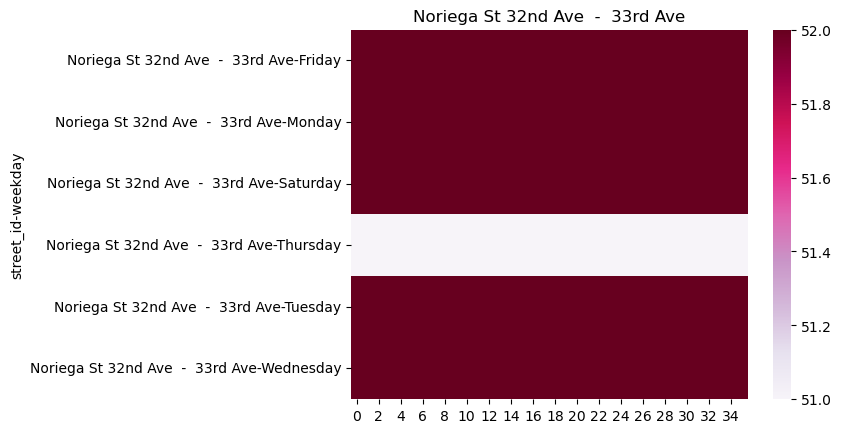

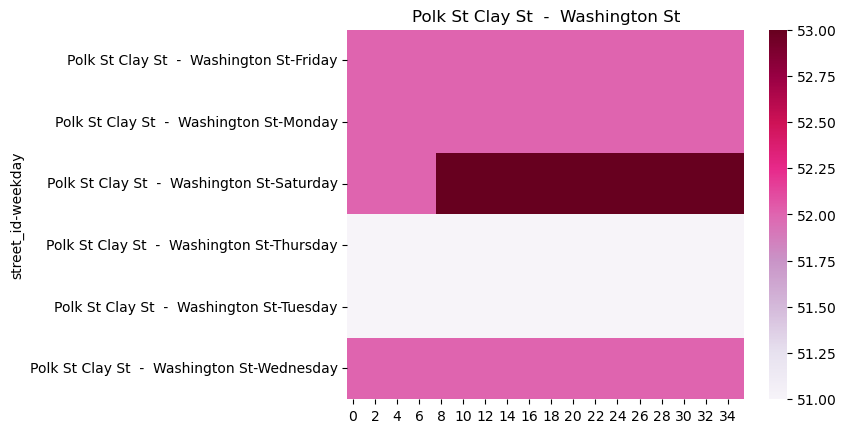

In [ ]:
# plot counts of illegal parking on each street

# for street_id in df['street_id'].unique():
#     slc = count_illegal_df.iloc[count_illegal_df.index.get_level_values('street_id') == street_id]
#     sns.heatmap(slc, cmap = "PuRd").set(title=street_id)
#     plt.show()